In [2]:
from parse_data import get_data


df = get_data()

In [3]:
df["creation_time"][0] - df["creation_time"][1]

-427061

In [4]:
average_diff = 0

c_time = df["creation_time"]

for i in range(1, len(c_time)):
    average_diff += c_time[i] - c_time[i-1]
average_diff/(len(c_time)-1)

1582.8439455281562

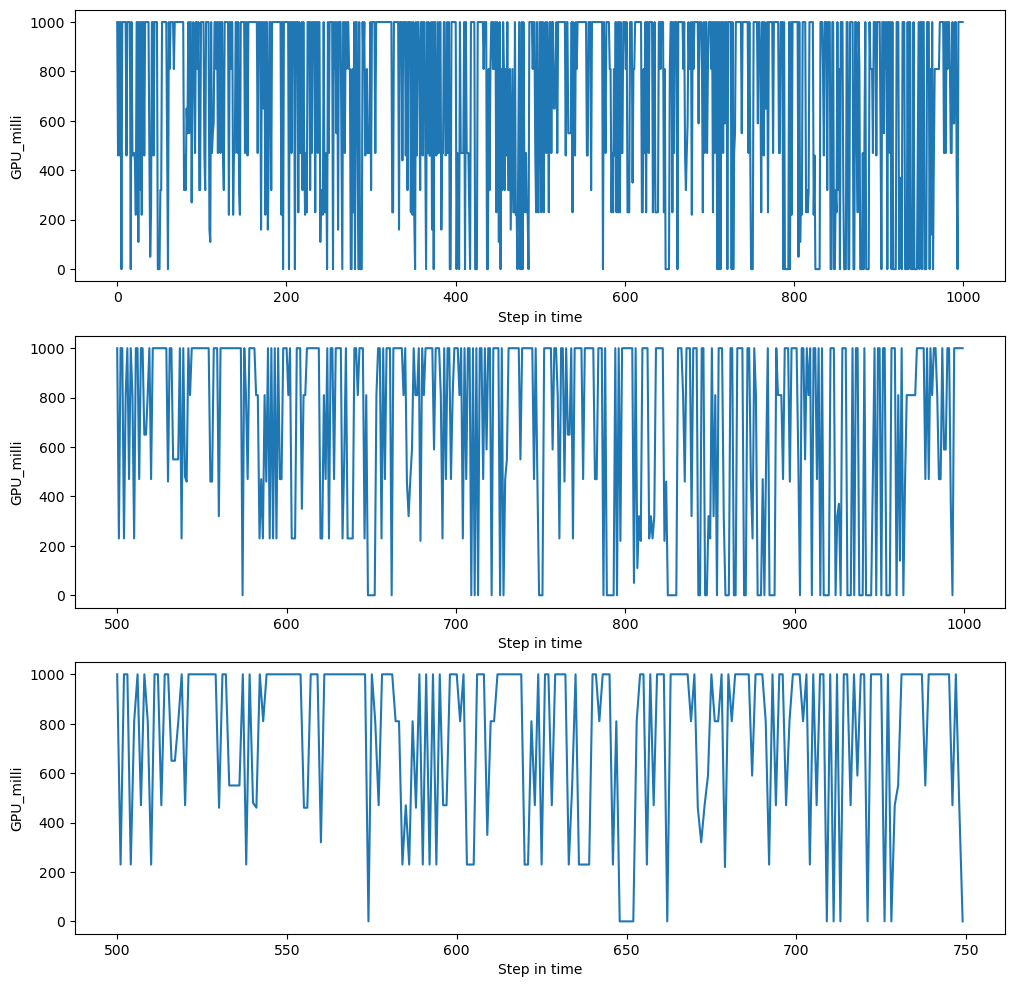

In [17]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(3, figsize=(12,12))


ax[0].plot([i for i in range(1000)], df["gpu_milli"][:1000])
ax[1].plot([i for i in range(500,1000)], df["gpu_milli"][500:1000])
ax[2].plot([i for i in range(500,750)], df["gpu_milli"][500:750])

for a in ax:
    a.set_xlabel("Step in time")
    a.set_ylabel("GPU_milli")
    
fig.savefig("output.png")


In [5]:
import torch.nn as nn


class PredictTime(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.hidden_size = 100
        self.hidden_layers = 5
        self.lstm = nn.LSTM(input_size=1, hidden_size=self.hidden_size, num_layers=self.hidden_layers).double()
        self.linear = nn.Linear(self.hidden_size,1).double()
        self.h_0 = torch.zeros(self.hidden_layers,self.hidden_size).double()
        self.c_0 = torch.zeros(self.hidden_layers,self.hidden_size).double()
        self.hidden = (self.h_0, self.c_0)
        self.sig = nn.Sigmoid()
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x, self.hidden = self.lstm(x,self.hidden)
        x = self.relu(x)
        x = self.linear(x)
        return self.sig(x)
    
    def init_state(self):
        self.h_0 = self.hidden[0].detach()
        self.c_0 = self.hidden[1].detach()
        self.hidden = (self.h_0, self.c_0)
    
    def clean_state(self):
        self.h_0 = torch.zeros(self.hidden_layers,self.hidden_size).double()
        self.c_0 = torch.zeros(self.hidden_layers,self.hidden_size).double()
        self.hidden = (self.h_0, self.c_0)
       

In [6]:
import torch

def make_data(df):
    
    x_train, y_train = [], []
    prev = -1
    
    m = df.max()[0]
    print("Max value: ", m)
    count = 0
    for row in df.values:
        x_train.append([count])
        count += 1
        y_train.append([row[0]/m])
    return torch.tensor(x_train, dtype=torch.double)/count,torch.tensor(y_train, dtype=torch.double)

make_data(df)
        

Max value:  1000


(tensor([[0.0000e+00],
         [1.2267e-04],
         [2.4534e-04],
         ...,
         [9.9963e-01],
         [9.9975e-01],
         [9.9988e-01]], dtype=torch.float64),
 tensor([[1.0000],
         [0.4600],
         [1.0000],
         ...,
         [0.4600],
         [0.5900],
         [0.5900]], dtype=torch.float64))

In [7]:
import numpy as np
import torch.optim as optim
import torch.utils.data as data
from IPython.display import clear_output

model = PredictTime()
optimizer = optim.Adam(model.parameters(), lr=0.1)
loss = nn.MSELoss()
batch_size = 100
x_d, y_d = make_data(get_data())
loader = data.DataLoader(data.TensorDataset(x_d,y_d), batch_size=batch_size)
epochs = 1000
for e in range(epochs):
    model.train()
    #print(next(iter(loader)))
    model.clean_state()
    
    res = []
    for x, y in loader:
        
        #print("XXXX", x, "YYYY", y)
        
        model.init_state()
        y_pred = model(x.double())
        #print(y_pred, y)
        l = loss(y_pred, y)
        res.append(l)
        #print(l, np.sqrt(l.detach().numpy()))
        
    l = res[0]
    for i in res[1:]:
        l += i
    optimizer.zero_grad()
    l.backward()
    optimizer.step()
        
        
    if e % 10 != 0:
        continue
    #clear_output(wait=True)
    sum_loss = 0

    for x, y in loader:
        model.eval()
        with torch.no_grad():
            y_pred = model(x)
            sum_loss += np.sqrt(loss(y_pred, y))
    
    print("Epoch %d Loss %.4f" % (e, sum_loss))
    
    
#for d in df.values:


Max value:  1000
Epoch 0 Loss 36.4215
Epoch 10 Loss 29.6982
Epoch 20 Loss 29.7302
Epoch 30 Loss 29.6556
Epoch 40 Loss 29.6280
Epoch 50 Loss 29.6482
Epoch 60 Loss 29.6429
Epoch 70 Loss 29.6385
Epoch 80 Loss 29.6370
Epoch 90 Loss 29.6357
Epoch 100 Loss 29.6340


KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt

def eval_model(x,y,m):
    df = get_data() 
    maxtime = df.max()[1]

    res = []
    m.eval()
    m.clean_state()
    count  = 1
    val = x[0][0]
    for i in x:
        t = torch.tensor([[val]])
        val = m(t)
        count += 1
        val = i
        res.append(val.detach().numpy()[0])
    
    loss = nn.MSELoss()
    print(np.sqrt(loss(torch.tensor(res),y)))
    
    fig, ax = plt.subplots()
    
    ax.plot(res[:50])
    ax.plot(y[:50])

amount = 1000
eval_model(x_d,y_d,model)
